In [2]:
#@title Load station and meteorological model. Save fusion file

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import seaborn as sns

path_result = "/content/drive/MyDrive/Colab Notebooks/gpt/LECO/LECOfusion1.csv"

def transform_value_l(val):
    first_decimal = int(str(val)[2]) if len(str(val)) > 2 else 0
    return f'CL{first_decimal}'

def transform_value_m(val):
    first_decimal = int(str(val)[2]) if len(str(val)) > 2 else 0
    return f'CM{first_decimal}'

def transform_to_nearest_odd(arr):
    # Make a copy of the input array
    arr_copy = arr.copy()

    # Find even numbers
    even_indices = arr_copy % 2 == 0

    # Increment even numbers to the nearest odd number
    arr_copy[even_indices] += 1

    return arr_copy.astype(str)

def custom_round(value):
    if value > 9001:
        return str(9999)
    elif value < 1000:
        return str(500)
    else:
        return str(round(value / 1000) * 1000)



pd.options.display.max_rows = 999

station_raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LECO/input_files/LECOY2018Y2022.csv",
                          parse_dates=["time"]).dropna().set_index("time")

#Load
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LECO/input_files/lat43.302lon-8.377p4R4KmD1Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LECO/input_files/lat43.302lon-8.377p4R4KmD1Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LECO/input_files/lat43.302lon-8.377p4R4KmD1Y2020.csv",parse_dates=["time"])
mody2021 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LECO/input_files/lat43.302lon-8.377p4R4KmD1Y2021.csv",parse_dates=["time"])
mody2022 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LECO/input_files/lat43.302lon-8.377p4R4KmD1Y2022.csv",parse_dates=["time"])
df_all = pd.concat([mody2018,mody2019,mody2020,mody2021,mody2022]).drop(columns=["Unnamed: 0"]).set_index("time")


#wind direction to words
df_all["dir0_l"] = result = ["0" + c if len(c) == 2 else ("00" + c if len(c) == 1 else c) for c in (round(df_all["dir0"],-1).astype(int).astype(str))]
all = round(df_all["mod0"] * 1.94384, 0).astype(int).values
list_mod0 = ["0" + str(c) if len(c) == 1 else str(c) for c in transform_to_nearest_odd(all)]
df_all["wind"]=df_all["dir0_l"]+list_mod0+"kt"

#visibility words
"""
interval = pd.IntervalIndex.from_tuples([(-1.5, 20000),(20000,30000)])
labels = ['vi20d', 'vi20u']
df_all["visibility0_l"] = pd.cut(df_all["visibility0"], bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("str")
df_all[["visibility0_l","visibility0"]].sample(100)
"""
# Define the old and new min and max values
old_min = 26.731182
old_max = 24235.0
new_min = 50
new_max = 9999

# Calculate the scale (a) and shift (b) factors
a = (new_max - new_min) / (old_max - old_min)
b = new_min - a * old_min

df_all['visibility0_l'] = ((a * df_all['visibility0'] + b).round().astype(int)).apply(custom_round)

#rh in words
interval = pd.IntervalIndex.from_tuples([(-1.5, .80),(.80,100)])
labels = ['rhd80', 'rhu80']
df_all["rh0_l"] = pd.cut(df_all["rh0"], bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("str")
df_all[["rh0_l","rh0"]].sample(100)


#prec words
interval = pd.IntervalIndex.from_tuples([(-1.5, 0.1),(.1,180)])
labels = ['prec0n', 'prec0y']
df_all["prec0_l"] = pd.cut(df_all["prec0"], bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("str")
df_all[["prec0_l","prec0"]].sample(100)


#cfl words
df_all['cfl0_l'] = round(df_all["cfl0"],1).apply(transform_value_l)

#cfm words
df_all['cfm0_l'] = round(df_all["cfm0"],1).apply(transform_value_m)


#temp words
df_all["temp0_l"] = ["0" + c if len(c) == 1 else c for c in round(df_all["temp0"]-273.16,0).astype(int).astype(str)]

#temp dew words
df_all["tempd0_l"] = ["0" + c if len(c) == 1 else c for c in round((df_all["temp0"]-273.16)- (100 - df_all["rh0"]*100) / 5,0).astype(int).astype(str)]

#mslp words
pres = round(df_all["mslp0"]/100,0).astype(int).astype(str)
df_all["mslp0_l"] =[ "q"+p if len(p)==4 else "q0"+p for p in pres]

#time variables
df_all['hour'] = 'H' + df_all.index.hour.astype(str)
df_all['month'] = 'M' + df_all.index.month.astype(str)

#select variable met model
df_all["model_seed"]= df_all["wind"]+" "+df_all["visibility0_l"]+" "+df_all["prec0_l"]+" "+df_all["cfl0_l"]+" "+df_all["cfm0_l"]+" "+df_all["temp0_l"]+ " "+df_all["tempd0_l"]+" "+df_all["mslp0_l"]


station_raw["metar_o"] = station_raw["metar_o"].astype(str)
station_raw["metar_o"] = station_raw["metar_o"].str.split().apply(lambda x: ' '.join(x[2:]) if len(x) > 2 else '')
station_clean_auto = [station_raw["metar_o"][i].replace("AUTO"+ " ", "") for i in range(0,len(station_raw["metar_o"]))]
station_raw["metar_o"] =station_clean_auto

result = pd.concat([station_raw,df_all["model_seed"]],axis=1).dropna()
result["fusion"]= result["model_seed"]+" "+result["metar_o"]

#save fusion
result["fusion"].to_csv(path_result)

result["fusion"].sample(100).values

array(['00009kt 9999 prec0n CL0 CM1 20 15 q1018 36010KT 300V050 CAVOK 20/15 Q1017 NOSIG',
       '23013kt 9999 prec0n CL4 CM4 16 14 q1013 24009KT 200V260 9999 BKN020 17/14 Q1013',
       '29001kt 9999 prec0n CL0 CM0 16 11 q1013 35004KT 310V030 CAVOK 14/10 Q1016 NOSIG',
       '14005kt 9999 prec0n CL0 CM0 10 07 q1022 18006KT CAVOK 06/04 Q1020 NOSIG',
       '21007kt 9999 prec0n CL2 CM1 14 12 q1019 21010KT 170V240 9999 BKN021 15/12 Q1019 NOSIG',
       '02007kt 9999 prec0n CL4 CM0 16 15 q1023 02008KT 320V060 9999 OVC025 18/15 Q1022',
       '22007kt 9999 prec0n CL0 CM0 10 07 q1032 22007KT 9999 NCD 07/07 Q1031',
       '34009kt 9999 prec0n CL0 CM0 27 19 q1019 01005KT 290V060 9999 FEW025 25/18 Q1019 NOSIG',
       '28007kt 9999 prec0n CL0 CM1 14 12 q1019 33007KT 280V020 9999 FEW010 15/12 Q1018 TEMPO 4000 BR BKN010',
       '02011kt 9999 prec0n CL0 CM0 29 20 q1015 36008KT 310V060 CAVOK 26/19 Q1015 NOSIG',
       '16005kt 9999 prec0n CL0 CM0 08 08 q1021 18004KT 4100 0300 BR BCFG NSC 06/06 Q1

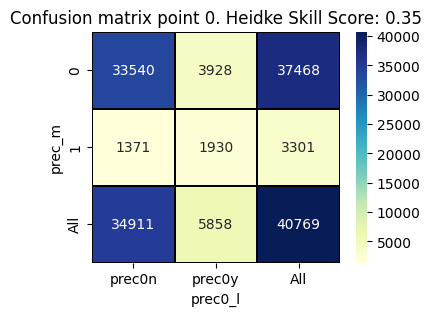

In [ ]:
#@title Precipitation
df_prec =pd.concat([df_all[["prec0_l","prec0"]],station_raw['wxcodes_o']],axis=1).dropna()
df_prec["prec_m"] = [1 if "RA" in c or "DZ" in c else 0 for c in df_prec["wxcodes_o"]]
df_prec

# Confussion matrix and Heidke skill score
cm0 = pd.crosstab(df_prec.prec_m, df_prec.prec0_l,margins=True)
a = cm0.values[0,0]
b = cm0.values[1,0]
c = cm0.values[0,1]
d = cm0.values[1,1]
HSS0 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)

plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 0. Heidke Skill Score: {}".format(HSS0))
seab0 = sns.heatmap(cm0,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()

,visibility0,visibility_o
visibility0,1.000000,0.158038
visibility_o,0.158038,1.000000


,visibility0,visibility_o,visibility0_l
count,40769.000000,40769.000000,40769.000000
mean,22913.283275,9295.864456,9515.627781
std,4668.362313,2036.840841,1938.867257
min,27.590639,48.000000,100.000000
25%,24039.722656,9994.000000,9999.000000
50%,24046.166016,9994.000000,9999.000000
75%,24096.097656,9994.000000,9999.000000
max,24235.000000,9994.000000,9999.000000


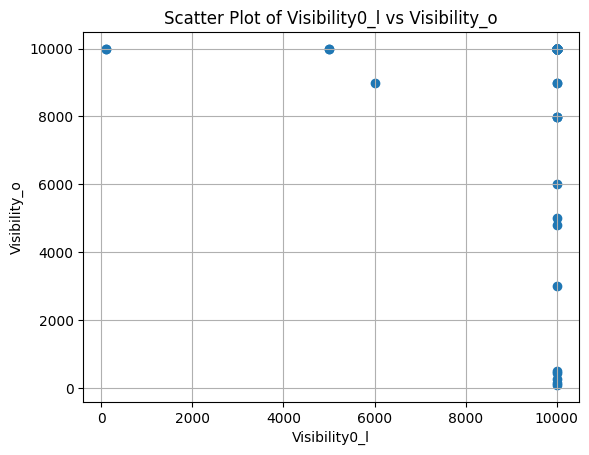

,visibility0,visibility_o,visibility0_l
time,,,
2022-10-17 20:00:00,24059.792969,9994.0,9999
2020-07-03 04:00:00,24038.689453,9994.0,9999
2022-11-19 02:00:00,24037.259766,8996.0,9999
2018-02-03 19:00:00,24043.095703,9994.0,9999
2020-07-29 07:00:00,36.423962,9994.0,100
2021-10-22 20:00:00,24049.458984,9994.0,9999
2020-08-12 20:00:00,24056.568359,9994.0,9999
2021-04-12 20:00:00,24068.201172,9994.0,9999
2021-10-20 08:00:00,24036.660156,9994.0,9999


visibility0_l
9999    37971
100      1136
4000      259
3000      249
5000      234
8000      198
2000      197
6000      179
7000      177
9000       93
1000       76
Name: count, dtype: int64

In [ ]:
#@title visibility0 vs visibility obs

def custom_round(value):
    if value > 9001:
        return 9999
    elif value < 1000:
        return 100
    else:
        return round(value / 1000) * 1000

df_vis = pd.concat([df_all["visibility0"],station_raw['visibility_o']],axis=1).dropna()
display(df_vis.corr())

# Define the old and new min and max values
old_min = 26.731182
old_max = 24235.0
new_min = 50
new_max = 9999

# Calculate the scale (a) and shift (b) factors
a = (new_max - new_min) / (old_max - old_min)
b = new_min - a * old_min

df_vis['visibility0_l'] = ((a * df_vis['visibility0'] + b).round().astype(int)).apply(custom_round)

display(df_vis.describe())
df_vis_s = df_vis.sample(100)
plt.scatter(df_vis_s['visibility0_l'], df_vis_s['visibility_o'])
plt.xlabel('Visibility0_l')
plt.ylabel('Visibility_o')
plt.title('Scatter Plot of Visibility0_l vs Visibility_o')
plt.grid(True)
plt.show()
display(df_vis.sample(30))
display(df_vis["visibility0_l"].value_counts())

,cfh0,cfl0,cfm0,visibility_o
cfh0,1.000000,0.057575,0.485161,0.092752
cfl0,0.057575,1.000000,0.389017,-0.001729
cfm0,0.485161,0.389017,1.000000,0.130663
visibility_o,0.092752,-0.001729,0.130663,1.000000


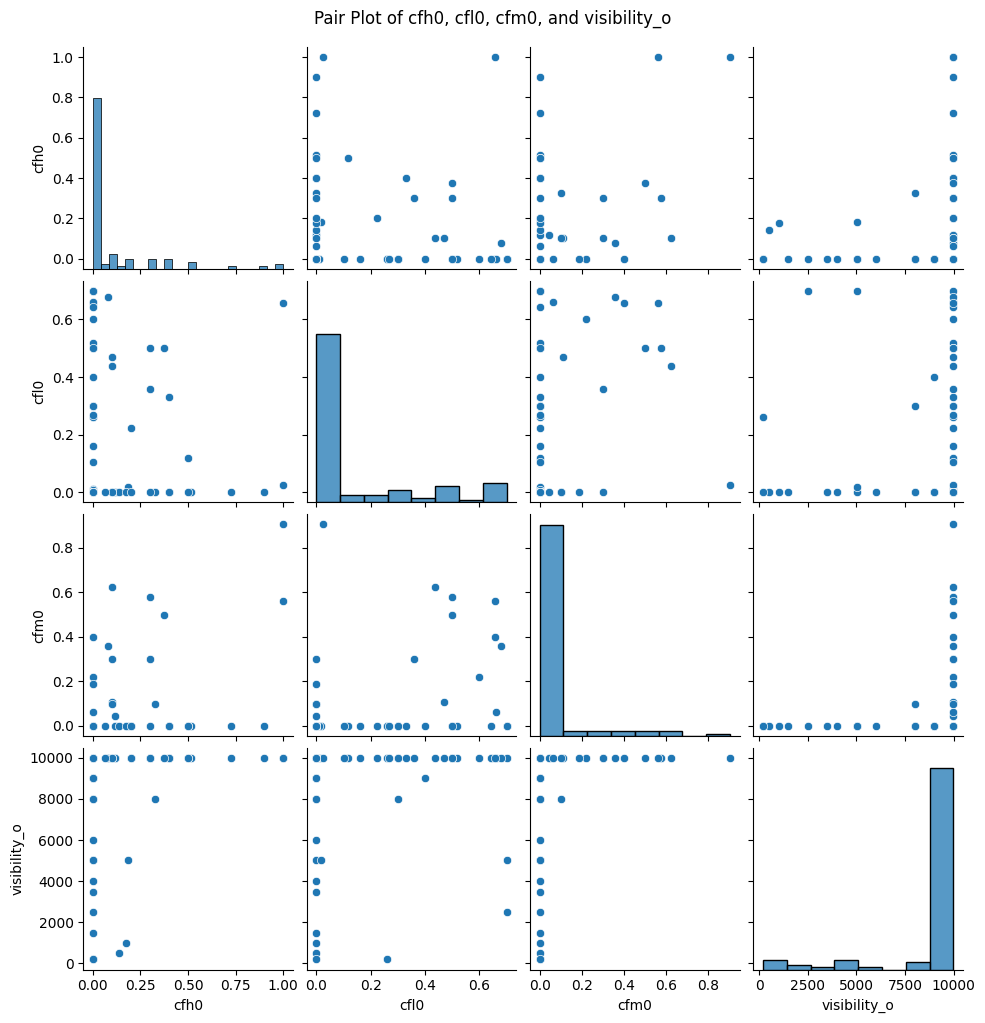

In [ ]:
#@title Clouds
df_clo = pd.concat([df_all[['cfh0', 'cfl0', 'cfm0']],station_raw['visibility_o']],axis=1).dropna().sample(100)
display(df_clo.corr())
sns.pairplot(df_clo)
plt.suptitle('Pair Plot of cfh0, cfl0, cfm0, and visibility_o', y=1.02)
plt.show()


In [ ]:
def transform_value(val):
    first_decimal = int(str(val)[2]) if len(str(val)) > 2 else 0
    return f'CL{first_decimal}'

df_all["cfl0"] = round(df_all["cfl0"],1)
df_all['cfl0_l'] = df_all['cfl0'].apply(transform_value)
df_all[["cfl0","cfl0_l"]]

,cfl0,cfl0_l
time,,
2018-01-01 01:00:00,0.0,CL0
2018-01-01 02:00:00,0.0,CL0
2018-01-01 03:00:00,0.0,CL0
2018-01-01 04:00:00,0.4,CL4
2018-01-01 05:00:00,0.0,CL0
...,...,...
2022-12-31 19:00:00,0.0,CL0
2022-12-31 20:00:00,0.0,CL0
2022-12-31 21:00:00,0.0,CL0


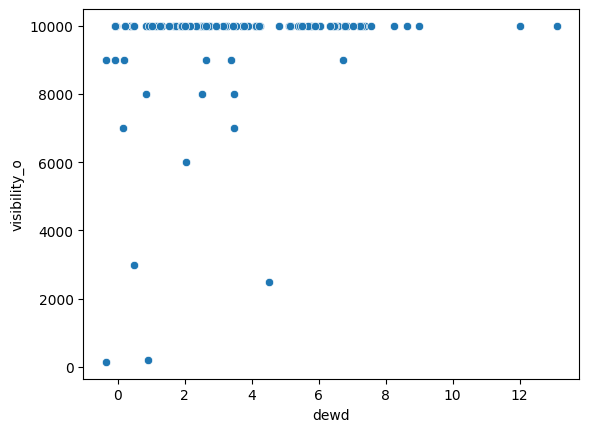

In [ ]:
#@title Temperature minus temperature dew point
#dew_temperature = dry_temperature - (100 - relative_humidity) / 5
df_all["dewd"] = df_all["temp0"]-round(df_all["temp0"]- (100 - df_all["rh0"]*100) / 5,0)
vis = pd.concat([df_all["dewd"],station_raw["visibility_o"]],axis=1).dropna()
vis.describe()
sns.scatterplot(vis.sample(100),x="dewd",y="visibility_o");

In [ ]:
vis.describe()

,dewd,visibility_o
count,40769.000000,40769.000000
mean,3.589733,9295.864456
std,2.877702,2036.840841
min,-0.499878,48.000000
25%,1.215698,9994.000000
50%,3.076111,9994.000000
75%,5.504486,9994.000000
max,14.500488,9994.000000


In [ ]:
def get_nth_word(text, n):
    # Split the text into words
    words = text.split()
    # Check if the index n is valid
    if n <= 0 or n > len(words):
        return "Invalid index"
    # Get the nth word (indexing starts from 1)
    return words[n - 1]


result["wind_metar"] = [get_nth_word(text, 7) for text in result.fusion]
result["wind_metar"] = result["wind_metar"].astype(str)
result["wind_metar"].value_counts()

wind_metar
12    3436
09    3403
11    3400
10    3376
13    3253
08    3115
14    3099
15    2656
07    2564
16    2349
06    2253
17    1612
05    1601
04    1201
18     929
03     759
19     520
02     435
01     254
20     191
00     144
21      83
-1      65
22      30
-2      19
23      10
-3       8
24       3
-4       1
Name: count, dtype: int64

In [ ]:
pd.options.display.max_rows = 999
win = pd.concat([result["wind_metar"],df_all],axis=1).dropna()
win["g"] = ["y" if 'G' in t else "n" for t in win.wind_metar]
win["g"].value_counts(normalize=True)

g
n    1.0
Name: proportion, dtype: float64

In [ ]:
win["dif_int"] = win["wind_gust0"]-win["mod0"]
win[win.g=="y"][["mod0","wind_gust0","wind_metar"]].sample(100)

ValueError: a must be greater than 0 unless no samples are taken

In [ ]:
win[win.g=="y"]["wind_gust0"].describe()

count    2708.000000
mean       15.374798
std         4.341556
min         0.360282
25%        12.522136
50%        15.357202
75%        18.211459
max        29.232828
Name: wind_gust0, dtype: float64

In [ ]:
win[win.wind_gust0>11]["g"].value_counts()

g
n    5254
y    2299
Name: count, dtype: int64

In [ ]:
sns.pairplot(win[win.dif_int>5][["mod0","wind_gust0","g"]],  hue='g',);

AttributeError: 'DataFrame' object has no attribute 'dif_int'

In [ ]:
win["wind_gust0"].describe()

count    41600.000000
mean         7.160643
std          4.428968
min          0.023710
25%          3.834732
50%          6.231800
75%          9.638942
max         29.232828
Name: wind_gust0, dtype: float64

In [ ]:
win["dif_int"].describe()

count    41600.000000
mean         2.508166
std          2.341852
min         -2.447657
25%          0.790846
50%          1.655715
75%          3.916108
max         16.575441
Name: dif_int, dtype: float64